In [11]:
import os
import pickle
import blosc
import matplotlib.pyplot as plt
import numpy as np
from coincidences_analyzer import calculate_coincidences, cfg

def decompress_data_blosc(compressed_data):
    """
    Decompresses the data structure using blosc.
    """
    # Decompress and deserialize
    serialized_data = blosc.decompress(compressed_data)
    data = pickle.loads(serialized_data)
    return data

def open_pickle_file(file_path, ssh_client=None):
    """
    Opens a single pickle file and returns its content.
    Supports both local and remote file reading via SSH.
    
    :param file_path: Path to the pickle file.
    :param ssh_client: Paramiko SSH client for remote access (required if remote=True).
    :return: Loaded pickle data.
    """
    if ssh_client:
        if ssh_client is None:
            raise ValueError("SSH client must be provided for remote access.")
        
        with ssh_client.open_sftp() as sftp:
            with sftp.file(file_path, 'rb') as file:
                return pickle.load(file)
    else:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        
        with open(file_path, 'rb') as file:
            return pickle.load(file)

def list_files(directory, ssh_client=None):
    """
    Lists files in a given directory, supporting both local and remote (SSH) access.
    
    :param directory: Directory path to list files from.
    :param remote: Boolean indicating if the directory is on a remote server.
    :param ssh_client: Paramiko SSH client for remote access (required if remote=True).
    :return: List of filenames in the directory.
    """
    if ssh_client:
        if ssh_client is None:
            raise ValueError("SSH client must be provided for remote access.")
        with ssh_client.open_sftp() as sftp:
            return sftp.listdir(directory)  # List files from the remote directory
    else:
        return os.listdir(directory)  # List files from the local directory
    
def analyze_coincidences(alice_dir, bob_dir, start_epoch, num_seconds, config, ssh_client=None):
    """
    Parses pickle files from Alice and Bob, finds coincidences, and returns the results.
    
    :param alice_dir: Directory containing Alice's data.
    :param bob_dir: Directory containing Bob's data.
    :param start_epoch: Starting epoch time (integer, ignoring fractions).
    :param num_seconds: Number of seconds to analyze.
    :param decompress_func: Function to decompress data.
    :return: List of (epoch_time, coincidence count).
    """
    results = []
    
    for i in range(num_seconds):
        epoch_time = start_epoch + i
        
        alice_files = [f for f in list_files(alice_dir, ssh_client) if f.startswith(str(epoch_time)) and f.endswith('.pkl')]
        bob_files = [f for f in list_files(bob_dir, ssh_client) if f.startswith(str(epoch_time)) and f.endswith('.pkl')]

        
        if alice_files and bob_files:
            alice_data = decompress_data_blosc(open_pickle_file(os.path.join(alice_dir, alice_files[0]), ssh_client))
            bob_data = decompress_data_blosc(open_pickle_file(os.path.join(bob_dir, bob_files[0]), ssh_client))
            coincidences = calculate_coincidences(config, alice_data, bob_data)
            results.append((epoch_time, coincidences))
        else:
            results.append((epoch_time, 0))
    
    return results


def plot_coincidences(results):
    """
    Plots all relevant data from coincidence analysis.
    """
    times = []
    coincidences_rates = []
    channel1_rates = []
    channel2_rates = []
    
    for epoch_time, coincidence_result in results:
        if coincidence_result:
            times.append(epoch_time)
            coincidences_rates.append(coincidence_result["coincidences_rate"])
            channel1_rates.append(coincidence_result["channel1_rate"])
            channel2_rates.append(coincidence_result["channel2_rate"])
    
    plt.figure(figsize=(10, 6))
    plt.plot(times, coincidences_rates, marker='o', linestyle='-', label="Coincidence Rate")
    plt.plot(times, channel1_rates, marker='s', linestyle='--', label="Channel 1 Rate")
    plt.plot(times, channel2_rates, marker='d', linestyle='-.', label="Channel 2 Rate")
    
    plt.xlabel("Epoch Time (s)")
    plt.ylabel("Rate")
    plt.title("Coincidence Analysis Between Alice and Bob")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot histogram for the last timestamp
    if results and results[-1][1]:
        last_result = results[-1][1]
        plt.figure(figsize=(10, 5))
        plt.bar(last_result["bin_edges"][:-1], last_result["histo_vals"], width=np.diff(last_result["bin_edges"]), align='edge', alpha=0.7)
        plt.axvline(x=last_result["window_low"], color='r', linestyle='--', label="Low Window Bound")
        plt.axvline(x=last_result["window_high"], color='g', linestyle='--', label="High Window Bound")
        plt.xlabel("Time Difference (ps)")
        plt.ylabel("Counts")
        plt.title("Histogram of Time Differences for Last Epoch")
        plt.legend()
        plt.grid()
        plt.show()

In [13]:
config = cfg(peak0=0,
             range_ns=0.1,
             time_bin=0.01,
             time_integration_ms=None,
             low_coinc_windows=-10,
             high_coinc_windows=10
             )

# Example usage
alice_data_path = 'data/2/'
bob_data_path = 'data/2/'
start_epoch = 1741698796  # Starting second
num_seconds = 5  # Number of next seconds to analyze
results = analyze_coincidences(alice_data_path, bob_data_path, start_epoch, num_seconds, config)


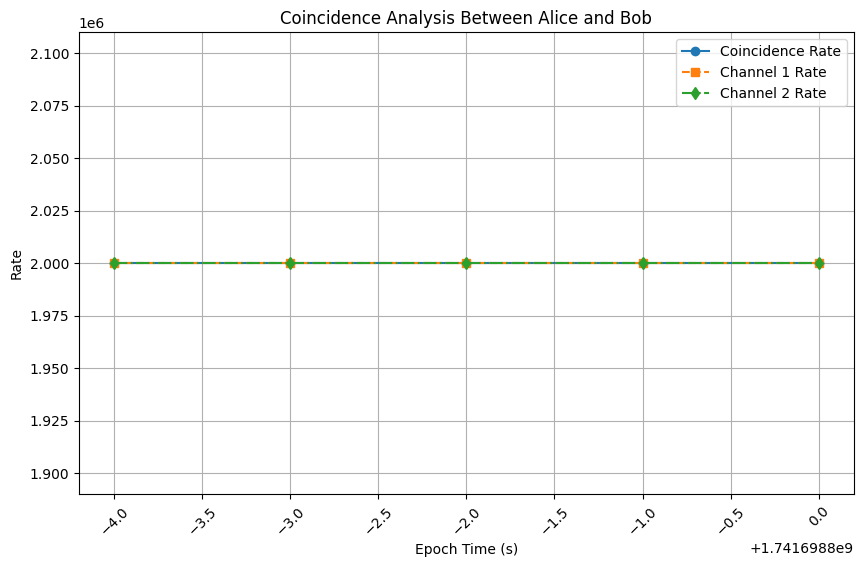

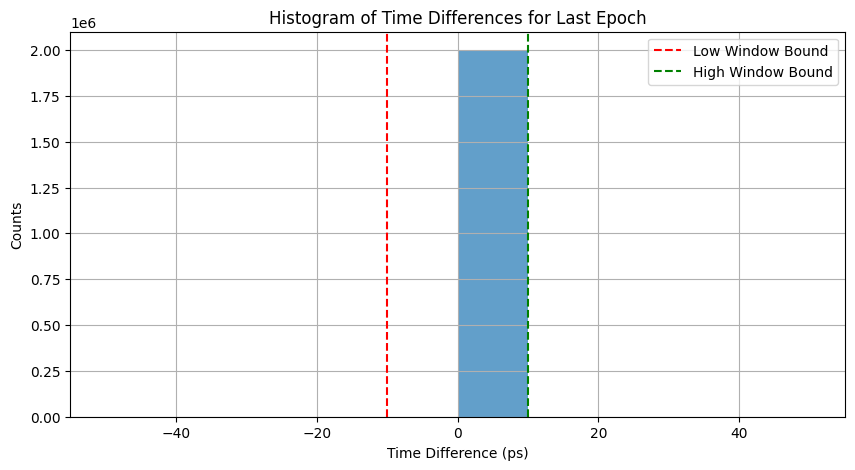

In [14]:
plot_coincidences(results)

In [ ]:
# use with remote stored data
import paramiko

ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname="your.remote.server", username="user", password="password")

config = cfg(peak0=0,
             range_ns=0.1,
             time_bin=0.01,
             time_integration_ms=None,
             low_coinc_windows=-10,
             high_coinc_windows=10
             )

# Example usage
alice_data_path = 'data/2/'
bob_data_path = 'data/2/'
start_epoch = 1741698796  # Starting second
num_seconds = 5  # Number of next seconds to analyze
results = analyze_coincidences(alice_data_path, bob_data_path, start_epoch, num_seconds, config, ssh)
